In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pandas as pd
import numpy as np

dataset_fname = "QSAR_dataset.xlsx"
test_fname = "test_TP1.xlsx"

---
title: "Title"
author: "Me"
header-includes:
  - \usepackage{siunitx}
output:
  pdf_document:
    keep_tex: true
---
```{r setup, include=FALSE}
knitr::opts_chunk$set(echo = TRUE)
```

# Représentation des données
Dans cette étape, nous devons:
- analyser chaque attribut;
- proposer un prétraitement des données;
- sélectionner les 10 meilleurs attributs avec justification statistique;
- visualiser la distribution des 10 meilleurs attributs.

Commençon par charger les données.

### Chargement des données

In [ ]:
# Chargement des données d'entraînement
df = pd.read_excel(dataset_fname, index_col=0)
# Lecture rapide des cinq premières entrées pour valider le chargement adéquat des données
df.head(5)

## Analyser chaque attribut

Dans cette étape, nous analyserons chacun des attributs. Plus spécifiquement, nous devons déterminer les types (catégories, ordinales, cycliques, quantitatifs, etc.) des nos données. Ensuite, nous devons filtrer les valeurs aberrantes ou manquantes. Finalement, nous pouvons procéder à une analyse statistique primaire (moyenne, variance, équart-type, etc.).

#### Attributs quantitatifs et qualitatifs
D'abord, commençons par distinguer les attributs qualitatifs des attributs quantitatifs. Nous portons une attention particulière aux attributs qualitatifs (ou catégoriques) car ceux-ci nécessitent du pré-traitement particulier.

In [ ]:
df.info()

In [ ]:
num_cols = df.select_dtypes(exclude=["object", "category"]).columns.tolist()
cat_cols = df.select_dtypes(include=["category", "object"]).columns.tolist()
print("Nombre d'attributs numériques: {}".format(len(num_cols)))
print("Nombre d'attributs catégoriques: {}".format(len(cat_cols)))
if len(cat_cols) > 0:
    print(cat_cols)

Seul l'attribut `Class` est catégorique, ce qui est normal puisqu'il associe une classe à chacune des observations. Tous nos attributs sont donc numériques, ce qui facilitera grandement notre prétraitement.

#### Valeurs aberrantes
Maintenant, détectons les valeurs abberantes ou invalides (`NaN`, `±inf`, etc.). Dans notre traitement, nous commençons par convertir les valeurs `±inf` en `NaN` afin d'éviter des duplicata de code. En effet, ces valeurs nécessiteront le même pré-traitement alors une stratégie optimale consiste à les considérer de la même façon dès le départ.

In [ ]:
df = df.replace([-np.inf, np.inf], np.nan)
nan_cols = df.columns[df.isna().any()]
nan_summary = df[nan_cols].isna().sum().sort_values(ascending=False)
nan_ratio = nan_summary / len(df)
nan_df = pd.concat((nan_summary, nan_ratio), axis=1)
nan_df = nan_df.rename(columns={0: "Count", 1: "Ratio"})
print(nan_df)

On constate que les variables `vsurf_V` et `vsurf_S` contiennent beaucoup de valeurs manquates (11.69% et 8.44% respectivement). Par contraste, `ASA+`, `ASA-`, `a_heavy` et `a_IC` contiennent seulement entre 1 et 2 observations invalides. Plus tard, nous pourrons probablement les supprimer sans affecter grandement la distribution des données.

#### Valeurs uniques
Finalement, nous devons considérons les valeurs uniques. Celles-ci ne sont pas techniquement invalides, mais peuvent néamoins être ignorées car elles ne contribueront pas à la décision des algorithmes. En effet, puisque ces attributs prennent une seule valeur distincte, elles ne seront pas déterminantes dans la tâche de classification.

In [ ]:
uniq_cols = df.columns[df.nunique() == 1]
uniq_cols

La liste `uniq_cols` est vide, ce qui implique que tous les attributs possèdent plusieurs valeurs distinctes.

#### Analyse statistique
On peut maintenant extraire certaines statistiques de base pour tous les attributs

In [ ]:
df_describe = df.describe()
df_describe

Cette analyse primaire nous indique que les différentes variables respectent des échelles de grandeur très différentes. Par exemple, `apol` $\in [17, 53]$ tandis que `vsurf_R` $\in [-6.8\mathrm{e+}08, 1.61\mathrm{e-}01]$. Ce constat nous indique qu'un centrage et réduction par équart-type des différentes variables est nécessaire.

Avant de procéder, nous devons gérer les données manquates identifiées précedemment. Commençons par afficher toutes les lignes invalides.

In [ ]:
df[df.isna().any(axis=1)]

On constate que les valeurs invalides pour `ASA-`, `a_heavy` et `a_IC` se trouvent toutes sur des lignes distinctes. Si elles étaient toutes associées à la même ligne, nous aurions pu simplement supprimer cette ligne et perdre moins de 1% des données. Puisque notre jeu de données possèdent seulement $n=154$ observations, les stratégies d'ablation sont rejetées par défaut si elles retirent un trop grand pourcentage des données. Une stratégie alternative consiste à remplacer les valeurs manquantes par une valeur bien représentative. Ainsi, ré-affichons les statistiques élémentaires pour les colonnes invalides seulement.

In [ ]:
df[nan_cols].describe()

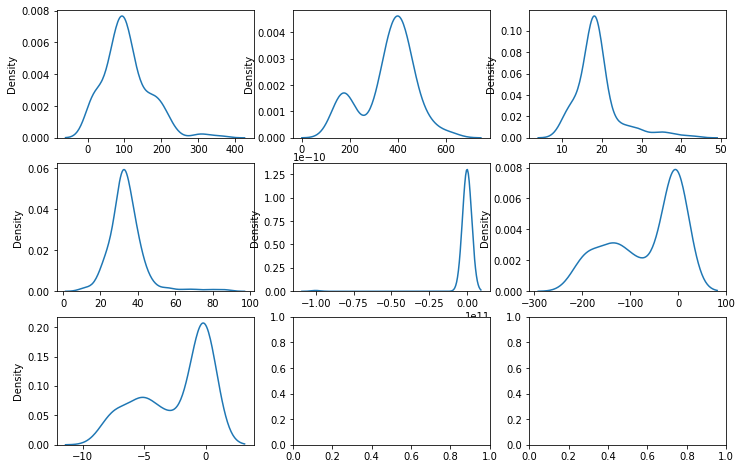

In [75]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,8))

# j = 0
# for i in range(len(nan_cols)):
#     col = nan_cols[i]
#     print(i % 3)
#     sns.kdeplot(df[[col]].to_numpy().reshape(-1), ax=axs[i % 3, j])
#     j += 1
#     if j > 2:
#         j = 0
sns.kdeplot(df[["ASA+"]].to_numpy().reshape(-1), ax=axs[0, 0])
sns.kdeplot(df[["ASA-"]].to_numpy().reshape(-1), ax=axs[0, 1])
sns.kdeplot(df[["a_heavy"]].to_numpy().reshape(-1), ax=axs[0, 2])
sns.kdeplot(df[["a_IC"]].to_numpy().reshape(-1), ax=axs[1, 0])
sns.kdeplot(df[["vsurf_R"]].to_numpy().reshape(-1), ax=axs[1, 1])
sns.kdeplot(df[["vsurf_S"]].to_numpy().reshape(-1), ax=axs[1, 2])
sns.kdeplot(df[["vsurf_V"]].to_numpy().reshape(-1), ax=axs[2, 0])

plt.show()

Les diagrammes de densité nous indique que la distribution des variables `a_heavy`, `a_IC` et `vsurf_R` sont plutôt concentrées autour de leur moyenne respective. On peut donc remplacer les valeurs manquantes par la moyenne sans altérer la distribution ou introduire un biais ayant un impact significatif dans la tâche de classification. Pour les autres attributs, c'est-à-dire `ASA+`, `ASA-`, `vsurf_S` et `vsurf_V` , on utilise plutôt la valeur médiane. Mentionner approche intéressante: K-NN ou maximiser le likelihood considérant les autres attributs.

In [79]:
# Remplacement des valeurs manquantes par la moyenne pour les attributs
# `a_heavy`, `a_IC` et `vsurf_R`.
for col in ["a_heavy", "a_IC", "vsurf_R"]:
    df.loc[:, col].fillna(df.loc[:, col].mean(), inplace=True)

# Remplacement des valeurs manquantes par la médiane pour les autres attributs restants
for col in set(nan_cols) - set(["a_heavy", "a_IC", "vsurf_R"]):
    df.loc[:, col].fillna(df.loc[:, col].median(), inplace=True)

# On valide la dernière opération en s'assurant qu'il ne reste aucun attribut avec des 
# valeurs manquates dans les données
df.isna().sum().sum()

0

Comme mentionné précédemment, les variables respectent des échelles de grandeur très différentes.
Il faut donc centrer et réduire les données.

In [94]:
from sklearn.preprocessing import StandardScaler

# On copie le dataframe (sans les étiquettes) dans une matrice numpy X
X = df.loc[:, df.columns != "Class"].to_numpy(dtype=np.float32)
# On applique un centrage et une réduction par équart-type de la matrice X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# On valide la dernière étape en s'assurant que les moyennes et écart-types 
# soient égaux à 0 et 1 respectivement
assert np.allclose(0., X_scaled.mean(axis=0), atol=1e-6), "Moyennes non centrées"
assert np.allclose(1., X_scaled.std(axis=0), atol=1e-6), "Écart-types différents de 1"


#### Analyse de la covariance
On peut maintenant évaluer la matrice de variance-covariance entre les attributs. 

In [ ]:
# Code inspiré de https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Pour éviter de la confusion, on calcule la matrice de covariance absolue.
# Ainsi, les cases bleues indiquent une absence de corrélation et les cases rouges l'inverse.
corr_mat = df[num_cols].corr().abs()
# On masque le haut de la matrice diagonale
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
f, ax = plt.subplots(figsize=(30, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat, annot=False, cmap=cmap)

In [ ]:
# Code inspiré de https://chrisalbon.com/code/machine_learning/feature_selection/drop_highly_correlated_features/
# Nous avons testé plusieurs ratio différents et celui-ci permettait de filtrer plusieurs attributs.
max_rho = 0.75
# Sélectionner triangle supérieur de la matrice de corrélation
upper = corr_mat.where(np.triu(np.ones_like(corr_mat), k=1).astype(bool))
# Sélectionner les attributs dont la corrélation dépasse le seuil `max_rho`
to_drop = [column for column in upper.columns if any(upper[column] >= max_rho)]
print("Total d'attributs dépassant le seuil {:.2f}: {}".format(max_rho, len(to_drop)))
print(to_drop)

In [ ]:
df_prime = df.drop(columns=to_drop, inplace=False)
print("Nombre d'attributs supprimés: {}".format(len(to_drop)))
print("Ratio : {:8.4f}".format(len(to_drop) / len(df)))
print("Nombre d'attributs restants: {}".format(len(df_prime.columns)))

In [ ]:
num_cols_prime = df_prime.select_dtypes(exclude=["object", "category"]).columns.tolist()
corr_mat_prime = df_prime[num_cols_prime].corr().abs()
# On masque le haut de la matrice diagonale
f, ax = plt.subplots(figsize=(30, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat_prime, annot=False, cmap=cmap)